In [106]:
import pandas as pd
import yfinance as yf
from collections.abc import Collection
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
from datetime import datetime, date, timedelta
import ast
import matplotlib.pyplot as plt
import statsmodels.api as sm
import requests
pd.set_option("display.max_rows", None)

In [ ]:
# TODO
# 1) this probably should pull stored values esp for back testing
# 2) maybe this should record the earliest date both assets have a price
def get_adj_close_history_df(tickers: list[str], start_date: str, end_date: str) -> pd.DataFrame:
    price_column_name_suffix = '_price'
    prices_df = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        progress=False,
        auto_adjust=True
    )['Close']
    prices_df.columns = [f"{col_name + price_column_name_suffix}" for col_name in prices_df.columns]
    return prices_df.dropna()

# NOTE: This methodology came from Caldeira & Caldeira 2013. Paper is in references folder
def is_price_series_integrated_of_order_one(
        price_series: pd.Series,
        pvalue_threshold: float = 0.05
) -> bool:
    p_level = adfuller(price_series)[1]
    # Test if series is stationary
    if p_level < pvalue_threshold:
        return False

    # Test if series is stationary after applying one difference
    p_diff = adfuller(price_series.diff().dropna())[1]
    return True if p_diff < pvalue_threshold else False


def is_pair_engle_granger_cointegrated(
        ticker1_price_series: pd.Series,
        ticker2_price_series: pd.Series,
        pvalue_threshold: float = 0.05
) -> bool:
    _, pvalue, _ = coint(ticker1_price_series, ticker2_price_series)
    return True if pvalue < pvalue_threshold else False

# TODO underwrite det_order and k_ar_diff parameter values
# current parameter values are from chatgpt
# also corroborated here https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/
def is_pair_johansen_cointegrated(
        pair_price_history_df: pd.DataFrame
) -> bool:
    johansen_cointegration_result = coint_johansen(
        pair_price_history_df.values,
        det_order=0,
        k_ar_diff=1
    )
    index_of_95_pct_confidence_level_critical_value = 1
    index_of_trace_stat = 0
    trace_stat = johansen_cointegration_result.lr1[index_of_trace_stat]
    critical_value = johansen_cointegration_result.cvt[
        0,
        index_of_95_pct_confidence_level_critical_value
    ]
    return trace_stat > critical_value
    
def is_pair_tradable(
        ticker_pair: tuple[str],
        start_date: str,
        end_date: str
) -> bool:
    try:
        pair_price_history_df = get_adj_close_history_df(ticker_pair, start_date, end_date)
        ticker1_price_series = pair_price_history_df.iloc[:,0]
        ticker2_price_series = pair_price_history_df.iloc[:,1]
        if not is_price_series_integrated_of_order_one(ticker1_price_series):
            print(f"Pair {ticker_pair} first ticker series is not I(1)")
            return False
        if not is_price_series_integrated_of_order_one(ticker2_price_series):
            print(f"Pair {ticker_pair} second ticker series is not I(1)")
            return False
        if not is_pair_engle_granger_cointegrated(ticker1_price_series, ticker2_price_series):
            print(f"Pair {ticker_pair} is not engle granger cointegrated")
            return False
        if not is_pair_johansen_cointegrated(pair_price_history_df):
            print(f"Pair {ticker_pair} is not johansen cointegrated")
            return False
        return True
    except Exception as e:
        print(f"Unable to evaluate pair {ticker_pair}")
        print(e)
        return False

def calculate_historical_gamma(
        pair_price_history_df: pd.DataFrame, 
        in_sample_start_date: datetime, 
        in_sample_end_date: datetime
) -> float:
    """
    Estimate gamma via OLS and return the spread = P1 - gamma * P2
    """
    date_mask = (pair_price_history_df.index >= in_sample_start_date) & (pair_price_history_df.index <= in_sample_end_date)
    pair_price_history_in_sample_df = pair_price_history_df[date_mask] 
    ticker1_price_series = pair_price_history_in_sample_df.iloc[:,0]
    ticker2_price_series = pair_price_history_in_sample_df.iloc[:,1]



    # Add constant to allow intercept in regression
    X = sm.add_constant(ticker2_price_series)
    model = sm.OLS(ticker1_price_series, X).fit()

    return float(model.params[1])

def calculate_spread(
        pair_price_history_df: pd.DataFrame,
        gamma: float,
        start_date: datetime, 
        end_date: datetime
) -> pd.Series:
    date_mask = (pair_price_history_df.index >= start_date) & (pair_price_history_df.index <= end_date)
    pair_price_history_out_of_sample_df = pair_price_history_df[date_mask] 
    ticker1_price_series = pair_price_history_out_of_sample_df.iloc[:,0]
    ticker2_price_series = pair_price_history_out_of_sample_df.iloc[:,1]

    return ticker1_price_series - gamma * ticker2_price_series

def calculate_trailing_zscore(spread: pd.Series, z_score_window_in_days: int, start_date: datetime, end_date: datetime) -> pd.Series:
    rolling_mean = spread.rolling(window=z_score_window_in_days).mean()
    rolling_std = spread.rolling(window=z_score_window_in_days).std()
    zscore_series = (spread - rolling_mean) / rolling_std
    zscore_filtered_series = zscore_series.loc[start_date:end_date]
    return zscore_filtered_series


# TODO add time series of prices on this graph for additional clarity
def plot_zscore_zeries(zscore_series: pd.Series):
    plt.figure(figsize=(14,6))
    plt.plot(zscore_series.index, zscore_series.values, label='Z-Score', color='blue')

    # Horizontal lines for 1 and 2 standard deviations
    for level in [1, 2]:
        plt.axhline(level, color='gray', linestyle='--', linewidth=1, label=f'+{level}σ' if level==1 else None)
        plt.axhline(-level, color='gray', linestyle='--', linewidth=1, label=f'-{level}σ' if level==1 else None)

    # Only show one label per line for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title('Trailing Z-Score of Spread (Out-of-Sample)')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.grid(True)
    plt.show()

def get_sp_500_ticker_pairs() -> list[tuple]:
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                            "AppleWebKit/537.36 (KHTML, like Gecko) "
                            "Chrome/115.0 Safari/537.36"}
    res = requests.get(url, headers=headers)
    res.raise_for_status()
    tables = pd.read_html(res.text)
    sp500_table = tables[0]  # first table on the page
    tickers = sp500_table['Symbol'].to_list()
    pairs = []
    for ticker_one in tickers:
        for ticker_two in tickers:
            if ticker_one == ticker_two:
                continue
            pairs.append((ticker_one, ticker_two))
    return pairs
    
# TODO should eventually create a generic abstraction that takes
# a universe (list of tickers) and returns a collection of tradable pairs.
# But that computation is time consuming and I already have a list of candidate pairs
# so I'm going to start there for now.

In [164]:
valid_pairs = []
seen_pairs = []
start_date = '2022-1-1'
end_date = '2023-12-31'


pairs = get_sp_500_ticker_pairs()

for pair in pairs:
    if sorted(pair) in seen_pairs:
        continue
    if is_pair_tradable(pair, start_date, end_date):
        print("VALID:", pair)
        valid_pairs.append(pair)
        pd.DataFrame({"Valid Pairs": [pair]}).to_csv(
                    '../data/valid_sp500_pairs.csv',
                    mode="a",      # append mode
                    header=False,  # don’t write header again
                    index=False
                )
    seen_pairs.append(sorted(pair))

/var/folders/9t/v6gpfcbs71bcpv1bsh004rrc0000gn/T/ipykernel_63239/2191747880.py:156: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(res.text)


Pair ('MMM', 'AOS') is not engle granger cointegrated
Pair ('MMM', 'ABT') first ticker series is not I(1)
Pair ('MMM', 'ABBV') first ticker series is not I(1)
Pair ('MMM', 'ACN') first ticker series is not I(1)
Pair ('MMM', 'ADBE') is not engle granger cointegrated
Pair ('MMM', 'AMD') is not engle granger cointegrated
Pair ('MMM', 'AES') is not engle granger cointegrated
Pair ('MMM', 'AFL') is not engle granger cointegrated
Pair ('MMM', 'A') is not engle granger cointegrated
Pair ('MMM', 'APD') is not engle granger cointegrated
Pair ('MMM', 'ABNB') is not engle granger cointegrated
Pair ('MMM', 'AKAM') is not engle granger cointegrated
Pair ('MMM', 'ALB') is not engle granger cointegrated
Pair ('MMM', 'ARE') is not engle granger cointegrated
Pair ('MMM', 'ALGN') first ticker series is not I(1)
Pair ('MMM', 'ALLE') is not engle granger cointegrated


KeyboardInterrupt: 

/var/folders/9t/v6gpfcbs71bcpv1bsh004rrc0000gn/T/ipykernel_63239/2191747880.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return float(model.params[1])


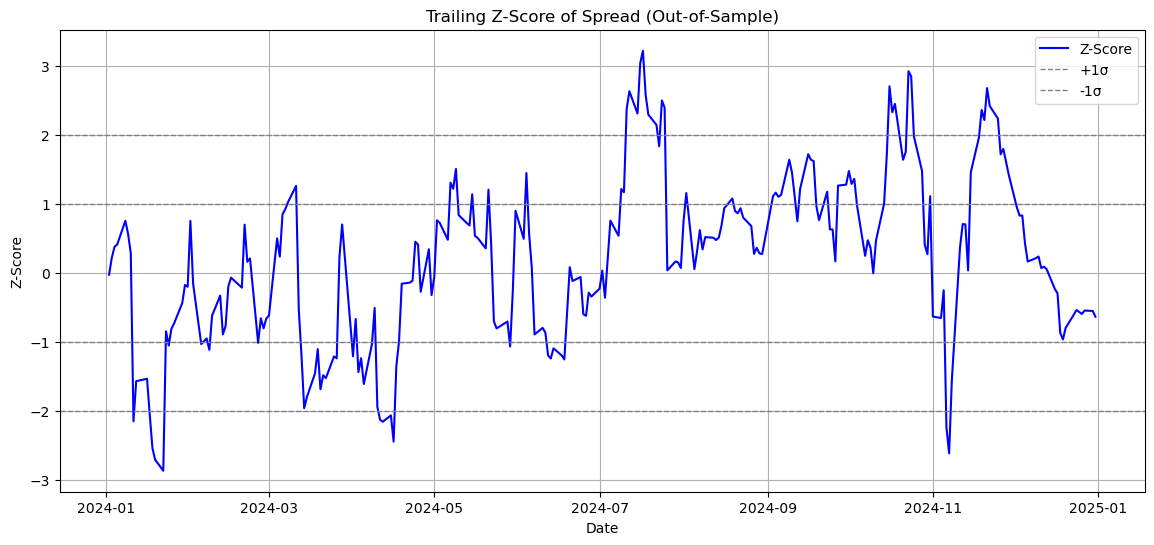

In [173]:
in_sample_start_date = datetime(2022,1,1)
in_sample_end_date = datetime(2023,12,31)

z_score_window_in_days = 50

out_of_sample_start_date = in_sample_end_date + timedelta(days=1)
out_of_sample_end_date = datetime(2025,1,1)

df = pd.read_csv('../data/valid_sp500_pairs.csv', header=None, names=['Pairs'])
df['Pairs'] = df['Pairs'].apply(ast.literal_eval)


for ticker_pair in df['Pairs'].to_list()[:1]:

    # Get prices once for entire evaluation period
    pair_price_history_df = get_adj_close_history_df(ticker_pair, in_sample_start_date, out_of_sample_end_date)
    # calculate gamma over period where cointegration has been validated
    gamma = calculate_historical_gamma(pair_price_history_df, in_sample_start_date, in_sample_end_date)

    # Lagging the out of sample start date is to ensure that there are z scores for the first day of the out of sample period
    #TODO there is a bug here bc pair price history is in trading days but the timedelta calculates in calendar days.
    # doubling the window fixed it for now but it is not precise. 
    spread_series = calculate_spread(
        pair_price_history_df,
        gamma,
        out_of_sample_start_date - timedelta(days=z_score_window_in_days*2),
        out_of_sample_end_date
    )
    out_of_sample_z_score_series = calculate_trailing_zscore(
        spread_series,
        z_score_window_in_days,
        out_of_sample_start_date,
        out_of_sample_end_date
    )
    plot_zscore_zeries(out_of_sample_z_score_series)

In [182]:
def create_returns_from_price_history(price_history_df: pd.DataFrame) -> pd.DataFrame:
    pair_price_returns_df = price_history_df.pct_change() * 100
    pair_price_returns_df.columns = pair_price_returns_df.columns.str.replace(r'_price$', '_1d_returns', regex=True)
    return pair_price_returns_df


def is_exit_condition_met(
        spread_z_score_series: pd.Series,
        t_minus_one_date: datetime,
        t_minus_two_date: datetime,
        exit_threshold: float
) -> bool:
    z_score_at_t_minus_one_date = spread_z_score_series.loc[t_minus_one_date]
    z_score_at_t_minus_two_date = spread_z_score_series.loc[t_minus_two_date]
    # upwards mean reversion across exit threshold
    if z_score_at_t_minus_one_date > exit_threshold and z_score_at_t_minus_two_date < exit_threshold:
        return True
    # downwards mean reversion across exit threshold
    if z_score_at_t_minus_one_date < exit_threshold and z_score_at_t_minus_two_date > exit_threshold:
        return True
    if np.isclose(z_score_at_t_minus_one_date, exit_threshold, atol=0.1):
        return True
    return False


def get_date_of_previous_day(
        spread_z_score_series: pd.Series,
        index: int,
) -> datetime:
    return spread_z_score_series.index[index - 1]


def set_weights_to_zero_at_current_date(
        weight_at_date_df: pd.DataFrame,
        date: datetime,
        ticker_one_weight_column_name: str,
        ticker_two_weight_column_name: str,
) -> pd.DataFrame:
    weight_at_date_df.loc[date, ticker_one_weight_column_name] = 0
    weight_at_date_df.loc[date, ticker_two_weight_column_name] = 0
    return weight_at_date_df


def enter_position_at_current_date(
        weight_at_date_df: pd.DataFrame,
        date: datetime,
        ticker_one_weight_column_name: str,
        ticker_two_weight_column_name: str,
        *,
        is_long_ticker_one: bool
)  -> pd.DataFrame:
    long_position_flag = 1
    short_position_flag = -1
    if is_long_ticker_one:
        weight_at_date_df.loc[date, ticker_one_weight_column_name] = long_position_flag
        weight_at_date_df.loc[date, ticker_two_weight_column_name] = short_position_flag
    else:
        weight_at_date_df.loc[date, ticker_one_weight_column_name] = short_position_flag
        weight_at_date_df.loc[date, ticker_two_weight_column_name] = long_position_flag
    return weight_at_date_df


def assign_weights_from_prev_date_to_cur_date(
        weight_at_date_df: pd.DataFrame,
        cur_date: datetime,
        t_minus_one_date: datetime,
) -> pd.DataFrame:
    weight_at_date_df.loc[cur_date] = weight_at_date_df.loc[t_minus_one_date]
    return weight_at_date_df


def create_trade_signals_for_spread_z_score_series(
        ticker_pair: tuple[str,str],
        spread_z_score_series: pd.Series,
) -> pd.DataFrame:
    ticker_one = ticker_pair[0]
    ticker_two = ticker_pair[1]
    weight_column_name_suffix = '_trade_side'
    ticker_one_weight_column_name = ticker_one + weight_column_name_suffix
    ticker_two_weight_column_name = ticker_two + weight_column_name_suffix

    weight_at_date_df = pd.DataFrame(
        index=spread_z_score_series.index,
        columns=[ticker_one_weight_column_name, ticker_two_weight_column_name]
    )
    entrance_threshold = 2
    exit_threshold = 0

    is_invested = False
    for i, (cur_date, z_score) in enumerate(spread_z_score_series.items()):
        # TODO there is a better way than to ignore the first two days. 
        # probably just extend the spread_z_score_series
        if i < 2:
            continue
        t_minus_one_date = spread_z_score_series.index[i-1]
        t_minus_two_date = spread_z_score_series.index[i-2]
        z_score_at_t_minus_one_date = spread_z_score_series.loc[t_minus_one_date]
    
        if z_score_at_t_minus_one_date >= entrance_threshold and not is_invested:
            weight_at_date_df = enter_position_at_current_date(
                weight_at_date_df,
                cur_date,
                ticker_one_weight_column_name,
                ticker_two_weight_column_name,
                is_long_ticker_one=True
            )
            is_invested = True

        elif is_invested and is_exit_condition_met(spread_z_score_series, t_minus_one_date, t_minus_two_date, exit_threshold):
            weight_at_date_df = set_weights_to_zero_at_current_date(
                                    weight_at_date_df,
                                    cur_date,
                                    ticker_one_weight_column_name,
                                    ticker_two_weight_column_name
                                )
            is_invested = False
        
        elif z_score_at_t_minus_one_date <= -entrance_threshold and not is_invested:
            weight_at_date_df = enter_position_at_current_date(
                weight_at_date_df,
                cur_date,
                ticker_one_weight_column_name,
                ticker_two_weight_column_name,
                is_long_ticker_one=False
            )
            is_invested = True
        else:
            weight_at_date_df = assign_weights_from_prev_date_to_cur_date(weight_at_date_df, cur_date, t_minus_one_date)
    
    return weight_at_date_df.fillna(0)

In [174]:
trade_signals_df = create_trade_signals_for_spread_z_score_series(ticker_pair, out_of_sample_z_score_series)
pair_price_returns_df = create_returns_from_price_history(pair_price_history_df)

/var/folders/9t/v6gpfcbs71bcpv1bsh004rrc0000gn/T/ipykernel_63239/1423615833.py:119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return weight_at_date_df.fillna(0)


In [179]:
trade_signals_df.head(10)

,MMM_trade_side,LNT_trade_side
Date,,
2024-01-02,0,0
2024-01-03,0,0
2024-01-04,0,0
2024-01-05,0,0
2024-01-08,0,0
2024-01-09,0,0
2024-01-10,0,0
2024-01-11,0,0
2024-01-12,-1,1


In [177]:
trade_signal_and_returns_df = trade_signals_df.merge(pair_price_returns_df, left_index=True, right_index=True)

In [ ]:
# the initial idea was to equal beta weight but I stupidly did not realize that I could end up with materially
# lob-sided trades if the betas of the two assets were not roughly equal which means the trade would not
# accurately capture the reversion of the spread. Hence, it seems that a prerequisite for pairing be that
# each asset have similar betas

def calculate_historical_betas(trade_signals_df: pd.DataFrame) -> pd.DataFrame:
    benchmark_ticker = 'IWV' # russell 3000 etf
    beta_calculation_window_in_days = 365 * 3 + 1
    column_names_with_embedded_tickers = list(trade_signals_df.columns)
    tickers = [
        column_name.split('_')[0]
        for column_name in column_names_with_embedded_tickers
    ]
    tickers.append(benchmark_ticker)

    start_date = trade_signals_df.index[0] - timedelta(days=beta_calculation_window_in_days)
    end_date = trade_signals_df.index[-1]

    prices_df = get_adj_close_history_df(
        tickers + [benchmark_ticker],
        start_date,
        end_date,
    )

    returns_df = create_returns_from_price_history(prices_df).dropna()
    benchmark_returns = returns_df[benchmark_ticker+'_1d_returns']
    betas = {}
    for ticker in tickers[:-1]:
        y = returns_df[ticker+'_1d_returns']
        X = sm.add_constant(benchmark_returns)
        model = sm.OLS(y, X).fit()
        betas[ticker] = model.params[1]  # slope = beta

    return pd.DataFrame.from_dict(betas, orient="index", columns=["beta"])


In [211]:
calculate_historical_betas(trade_signals_df).head(20)

/var/folders/9t/v6gpfcbs71bcpv1bsh004rrc0000gn/T/ipykernel_63239/2590961576.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = model.params[1]  # slope = beta
/var/folders/9t/v6gpfcbs71bcpv1bsh004rrc0000gn/T/ipykernel_63239/2590961576.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  betas[ticker] = model.params[1]  # slope = beta


,beta
MMM,0.722382
LNT,0.394200


In [ ]:
returns_df.head(20)

,IWV_1d_returns,LNT_1d_returns,MMM_1d_returns
Date,,,
2021-01-05,0.847756,-0.475355,-0.168712
2021-01-06,0.768643,1.492524,1.521156
2021-01-07,1.637172,-3.705868,-2.566154
2021-01-08,0.531068,0.488667,-1.826546
2021-01-11,-0.606859,-1.621045,-0.852239
2021-01-12,0.320667,-1.071076,0.792963
2021-01-13,0.105084,1.499087,-0.138132
2021-01-14,-0.148743,-1.353862,0.078191
2021-01-15,-0.788450,2.869623,-0.516788
